In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

2025-07-20 14:15:58.759396: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753020958.994778      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753020959.068448      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Thiết lập random seed 
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
TRAIN_DIR = "/kaggle/input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped"
LABELS_PATH = "/kaggle/input/diabetic-retinopathy-resized/trainLabels_cropped.csv"
IMG_SIZE = (380, 380)  
BATCH_SIZE = 16
EPOCHS = 10
NUM_CLASSES = 5

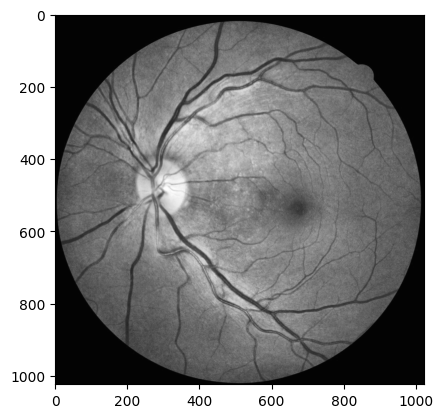

In [5]:
# Hàm tiền xử lý ảnh với CLAHE
def convert_CLAHE(image):

    # Lấy kênh green 
    green_channel = image[:, :, 1]
    
    # Áp dụng CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(green_channel)
    
    # Chuyển về 3 kênh để phù hợp với EfficientNet
    clahe_3channel = cv2.cvtColor(clahe_image, cv2.COLOR_GRAY2RGB)
    
    return clahe_3channel
plt.imshow(convert_CLAHE(cv2.imread("/kaggle/input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/10003_left.jpeg")))

In [6]:
# Hàm load và tiền xử lý ảnh
def load_and_preprocess_image(image_path, label):
   
    image = cv2.imread(image_path)
    if image is None:
        print(f"Không thể đọc ảnh: {image_path}")
        return None, None
    
    # CLAHE
    
    processed_image = convert_CLAHE(image)
    processed_image = cv2.resize(processed_image, IMG_SIZE)
    processed_image = processed_image.astype(np.float32) / 255.0
    return processed_image, label
load_and_preprocess_image("/kaggle/input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/10003_left.jpeg","hello")

(array([[[0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471],
         ...,
         [0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471]],
 
        [[0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471],
         ...,
         [0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471]],
 
        [[0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471],
         ...,
         [0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471]],
 
        ...,
 
        [[0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176

In [7]:
labels_df = pd.read_csv(LABELS_PATH)
len(labels_df)

35108

In [8]:
labels_df

,Unnamed: 0.1,Unnamed: 0,image,level
0,0,0,10_left,0
1,1,1,10_right,0
2,2,2,13_left,0
3,3,3,13_right,0
4,4,4,15_left,1
...,...,...,...,...
35103,35104,35121,44347_right,0
35104,35105,35122,44348_left,0
35105,35106,35123,44348_right,0
35106,35107,35124,44349_left,0


In [9]:
class_counts = labels_df['level'].value_counts().sort_index()
class_counts

level
0    25802
1     2438
2     5288
3      872
4      708
Name: count, dtype: int64

In [10]:
labels_df['image_path'] = labels_df['image'].apply(
    lambda x: os.path.join(TRAIN_DIR, f"{x}.jpeg")
)
labels_df

,Unnamed: 0.1,Unnamed: 0,image,level,image_path
0,0,0,10_left,0,/kaggle/input/diabetic-retinopathy-resized/res...
1,1,1,10_right,0,/kaggle/input/diabetic-retinopathy-resized/res...
2,2,2,13_left,0,/kaggle/input/diabetic-retinopathy-resized/res...
3,3,3,13_right,0,/kaggle/input/diabetic-retinopathy-resized/res...
4,4,4,15_left,1,/kaggle/input/diabetic-retinopathy-resized/res...
...,...,...,...,...,...
35103,35104,35121,44347_right,0,/kaggle/input/diabetic-retinopathy-resized/res...
35104,35105,35122,44348_left,0,/kaggle/input/diabetic-retinopathy-resized/res...
35105,35106,35123,44348_right,0,/kaggle/input/diabetic-retinopathy-resized/res...
35106,35107,35124,44349_left,0,/kaggle/input/diabetic-retinopathy-resized/res...


In [11]:
# Chia dữ liệu train/val/test với stratify
X = labels_df['image_path'].values
y = labels_df['level'].values

# Chia 70% train, 15% val, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp  # 0.176 tuong duong 0.15 trong 85% còn lại
)


X_train

array(['/kaggle/input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/10603_left.jpeg',
       '/kaggle/input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/17838_right.jpeg',
       '/kaggle/input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/37106_right.jpeg',
       ...,
       '/kaggle/input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44103_left.jpeg',
       '/kaggle/input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/1779_right.jpeg',
       '/kaggle/input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/22278_left.jpeg'],
      dtype=object)

In [12]:
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(y_train), 
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print(f"\nClass weights: {class_weight_dict}")


Class weights: {0: 0.2721416712783619, 1: 2.8808435852372583, 2: 1.327645788336933, 3: 8.048445171849426, 4: 9.914516129032258}


In [13]:
# Custom data generator với augmentation mạnh cho minority classes
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, labels, batch_size, img_size, 
                 is_training=True, augment_minority=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.is_training = is_training
        self.augment_minority = augment_minority
        self.indices = np.arange(len(image_paths))
        
        # Data augmentation cho training
        if is_training:
            self.datagen = ImageDataGenerator(
                rotation_range=15,
                width_shift_range=0.1,
                height_shift_range=0.1,
                shear_range=0.1,
                zoom_range=0.1,
                horizontal_flip=True,
                vertical_flip=True,
                brightness_range=[0.8, 1.2],
                channel_shift_range=0.1
            )
        else:
            self.datagen = None
            
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = []
        batch_y = []
        
        for i in batch_indices:
            image_path = self.image_paths[i]
            label = self.labels[i]
            
            # Load và preprocess ảnh
            image, _ = load_and_preprocess_image(image_path, label)
            if image is None:
                continue
                
            # Augmentation cho minority classes (level 1,2,3,4)
            if self.is_training and self.augment_minority and label > 0:
                # Áp dụng augmentation mạnh hơn cho minority classes
                image = np.expand_dims(image, 0)
                # Random augmentation
                aug_image = self.datagen.flow(image, batch_size=1).__next__()[0]
                # Thêm noise nhẹ
                noise = np.random.normal(0, 0.01, aug_image.shape)
                aug_image = np.clip(aug_image + noise, 0, 1)
                batch_x.append(aug_image)
            elif self.is_training and self.datagen is not None:
                # Augmentation nhẹ cho class 0
                if np.random.random() > 0.5:  # 50% chance augmentation
                    image = np.expand_dims(image, 0)
                    image = self.datagen.flow(image, batch_size=1).__next__()[0]
                batch_x.append(image)
            else:
                batch_x.append(image)
            
            batch_y.append(label)
        
        if len(batch_x) == 0:
            return np.zeros((1, *self.img_size, 3)), np.zeros((1, NUM_CLASSES))
            
        return np.array(batch_x), to_categorical(batch_y, NUM_CLASSES)
    
    def on_epoch_end(self):
        if self.is_training:
            np.random.shuffle(self.indices)


In [14]:
# Tạo data generators
train_generator = CustomDataGenerator(
    X_train, y_train, BATCH_SIZE, IMG_SIZE, is_training=True
)
val_generator = CustomDataGenerator(
    X_val, y_val, BATCH_SIZE, IMG_SIZE, is_training=False
)
test_generator = CustomDataGenerator(
    X_test, y_test, BATCH_SIZE, IMG_SIZE, is_training=False
)

In [15]:
# Xây dựng mô hình EfficientNet B4
def create_efficientnet_model():
    # Load EfficientNet B4 pretrained
    base_model = EfficientNetB4(
        weights='imagenet',
        include_top=False,
        input_shape=(*IMG_SIZE, 3)
    )
    
    # Freeze một số layers đầu
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    
    # Thêm custom head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

In [16]:
# Tạo mô hình
print("Đang tạo mô hình EfficientNet B4...")
model = create_efficientnet_model()
print(f"Tổng số parameters: {model.count_params():,}")

Đang tạo mô hình EfficientNet B4...


2025-07-20 14:22:02.821204: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Tổng số parameters: 18,724,452


In [21]:
# Compile mô hình
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [22]:
# Callbacks
callbacks = [
    ModelCheckpoint(
        'best_efficientnet_b4_dr.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

In [ ]:
# Huấn luyện mô hình
print("Bắt đầu huấn luyện...")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

Bắt đầu huấn luyện...
Epoch 1/10
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3418 - loss: 1.6205
Epoch 1: val_accuracy improved from -inf to 0.68190, saving model to best_efficientnet_b4_dr.h5
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 12570s 8s/step - accuracy: 0.3418 - loss: 1.6205 - val_accuracy: 0.6819 - val_loss: 1.3166 - learning_rate: 1.0000e-04
Epoch 2/10
1443/1537 ━━━━━━━━━━━━━━━━━━━━ 10:52 7s/step - accuracy: 0.3547 - loss: 1.5958

In [ ]:
# Load best weights
model.load_weights('best_efficientnet_b4_dr.h5')

In [ ]:
print("\nĐánh giá trên test set...")
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")

In [ ]:
# Dự đoán chi tiết
y_pred_proba = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = []
for i in range(len(test_generator)):
    _, batch_y = test_generator[i]
    y_true.extend(np.argmax(batch_y, axis=1))
y_true = np.array(y_true[:len(y_pred)])

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Vẽ learning curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['top_2_accuracy'], label='Train Top-2 Acc')
plt.plot(history.history['val_top_2_accuracy'], label='Val Top-2 Acc')
plt.title('Model Top-2 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Top-2 Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Lưu mô hình cuối cùng
model.save('final_efficientnet_b4_dr.h5')
print("\nĐã lưu mô hình tại: final_efficientnet_b4_dr.h5")

# Hàm dự đoán cho ảnh mới
def predict_single_image(image_path, model):
    """Dự đoán cho một ảnh đơn lẻ"""
    image, _ = load_and_preprocess_image(image_path, 0)
    if image is None:
        return None
    
    image = np.expand_dims(image, 0)
    pred_proba = model.predict(image, verbose=0)
    pred_class = np.argmax(pred_proba, axis=1)[0]
    confidence = pred_proba[0][pred_class]
    
    return {
        'predicted_class': class_names[pred_class],
        'confidence': confidence,
        'all_probabilities': dict(zip(class_names, pred_proba[0]))
    }
